In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import sklearn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import os 
import pathlib 
import random
import matplotlib.image as mpimg
import zipfile
import wget
import tensorflow_hub as hub

### Get Helper Functions

In [74]:
import requests
url = "https://raw.githubusercontent.com/Meta-c/Helper-ML/master/ML_functions.py"


response = requests.get(url)
code = response.text

exec(code)

### Getting Data

In [3]:
train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

In [4]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                            image_size=IMG_SIZE,label_mode="categorical",batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
image_size=IMG_SIZE,
label_mode="categorical",
batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
for images,labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[1.18790817e+02 1.03790817e+02 1.07505104e+02]
   [1.24688774e+02 1.11617348e+02 1.03974495e+02]
   [1.17790817e+02 1.08500000e+02 9.58724518e+01]
   ...
   [1.28520355e+02 1.35290787e+02 1.45367310e+02]
   [1.24433701e+02 1.33908218e+02 1.44193924e+02]
   [1.25158081e+02 1.38158081e+02 1.47158081e+02]]

  [[1.19525513e+02 1.04525513e+02 1.08239799e+02]
   [1.16852043e+02 1.03780617e+02 9.81377563e+01]
   [1.17642853e+02 1.07642853e+02 9.77295914e+01]
   ...
   [1.24142853e+02 1.33000000e+02 1.41642899e+02]
   [1.23285728e+02 1.36086746e+02 1.44153076e+02]
   [1.22806084e+02 1.36760162e+02 1.45760162e+02]]

  [[1.21000000e+02 1.06642860e+02 1.09714279e+02]
   [1.20158165e+02 1.09158165e+02 1.05301018e+02]
   [1.18877548e+02 1.08020409e+02 1.00306122e+02]
   ...
   [1.24596878e+02 1.35596878e+02 1.41505051e+02]
   [1.22928558e+02 1.35928558e+02 1.43499985e+02]
   [1.22714355e+02 1.37285782e+02 1.44500076e+02]]

  ...

  [[1.23872383e+02 1.23229523e+02 9.11580963e+01]
   [1

## Model 0 : building transfer learning model with functional API
 

In [6]:
# Create base model with tf.keras.applications

base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model =>underlying pre-trained patterns aren't updated

base_model.trainable=False

# Create inputs into our model

inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# Normalize in case of using (ResNet50v2)
# x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x=base_model(inputs)

# Average the outputs 

x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)


# Create the output activation layer

outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# Combine inputs with outputs 

model_0 = tf.keras.Model(inputs,outputs)


In [7]:
model_0.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [8]:
model_0_history=model_0.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
        validation_data=test_data,
        validation_steps=len(test_data),
        # callbacks=[
        #     create_tensorboard_callback(dir_name="tensorflow_hub",
        #                                 experiment_name="resnet50v2"       )]
         )

Epoch 1/5
24/24 [==============================] - 39s 1s/step - loss: 1.9042 - accuracy: 0.4067 - val_loss: 1.3659 - val_accuracy: 0.6836
Epoch 2/5
24/24 [==============================] - 11s 463ms/step - loss: 1.1338 - accuracy: 0.7613 - val_loss: 0.9393 - val_accuracy: 0.7920
Epoch 3/5
24/24 [==============================] - 11s 458ms/step - loss: 0.8253 - accuracy: 0.8227 - val_loss: 0.7619 - val_accuracy: 0.8204
Epoch 4/5
24/24 [==============================] - 11s 463ms/step - loss: 0.6738 - accuracy: 0.8507 - val_loss: 0.6670 - val_accuracy: 0.8356
Epoch 5/5
24/24 [==============================] - 10s 434ms/step - loss: 0.5733 - accuracy: 0.8720 - val_loss: 0.6118 - val_accuracy: 0.8400


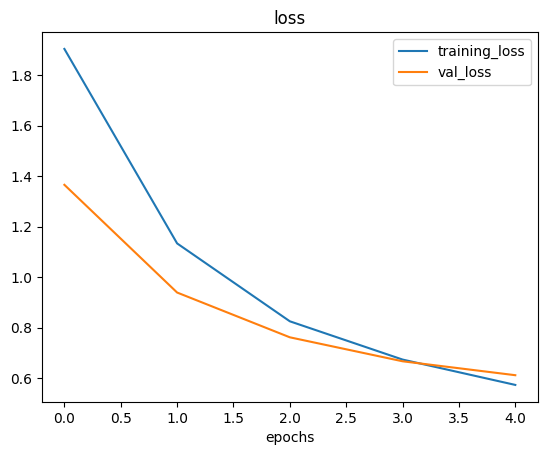

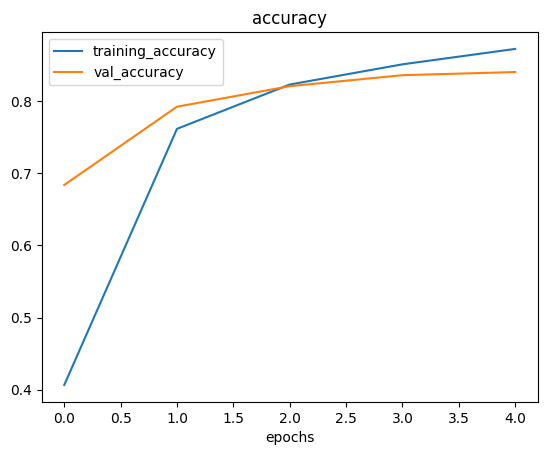

In [9]:
plot_loss_curves(model_0_history)

## Getting a feature vector from trained model

In [10]:
input_shape =(1,4,4,3)


# Create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)

print(f"Random input tensor:\n{input_tensor}\n")


# Pass the random tensor to Global average pooling 2D layer

global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"2D average pooled random tensor:\n{global_average_pooled_tensor}\n")

global_average_pooled_tensor.shape

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]



TensorShape([1, 3])

## Running a series of transfer learning experiments

In [11]:
# wget.download("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip")

# zip_ref=zipfile.ZipFile("10_food_classes_1_percent.zip")
# zip_ref.extractall()
# zip_ref.close()

In [12]:
train_dir_1_per="10_food_classes_1_percent/train/"
test_dir="10_food_classes_1_percent/test/"

In [13]:
# Setup data loaders

IMG_SIZE=(224,224)

train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_per,
                             label_mode="categorical" ,
                             image_size=IMG_SIZE,
                             batch_size=BATCH_SIZE
                             )


test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                             label_mode="categorical" ,
                             image_size=IMG_SIZE,
                             batch_size=BATCH_SIZE
                             )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model 

In [14]:
from tensorflow.keras.layers.experimental import preprocessing
# Create data aug

data_augmentation= tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    
],name="data_augmentation")

## Visualize our data aug layer

(-0.5, 409.5, 256.5, -0.5)

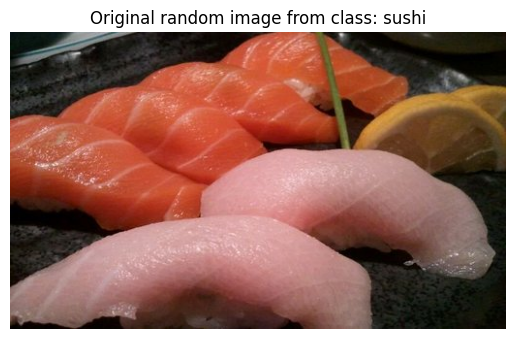

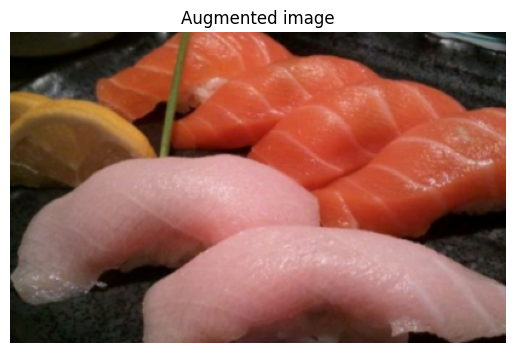

In [15]:
target_class=random.choice(train_data_1_percent.class_names)

target_dir="10_food_classes_1_percent/train/"+target_class 

random_image=random.choice(os.listdir(target_dir))

random_image_path=target_dir+"/"+random_image


# Read image 
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)


# Plot augmented random image

augmented_img=data_augmentation(img,training=True)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title("Augmented image")
plt.axis(False)

### Model 1: Feature extraction transfer learning on 1 % of the data augmentation

In [16]:
# Create base model with tf.keras.applications

base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model =>underlying pre-trained patterns aren't updated

base_model.trainable=False

# Create inputs into our model

inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# Normalize in case of using (ResNet50v2)
# x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Data augmentation layer
x= data_augmentation(inputs)


x=base_model(x)

# Average the outputs 

x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)


# Create the output activation layer

outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# Combine inputs with outputs 

model_1 = tf.keras.Model(inputs,outputs)

In [17]:
model_1.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [19]:
model_1_history=model_1.fit(train_data_1_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_1_percent),
        validation_data=test_data,
        validation_steps=0.25*len(test_data),
        # callbacks=[
        #     # create_tensorboard_callback(dir_name="transfer_learning",
        #     #                             experiment_name="1_percent_data_aug")]
         )

Epoch 1/5
3/3 [==============================] - 20s 6s/step - loss: 2.4428 - accuracy: 0.1429 - val_loss: 2.2227 - val_accuracy: 0.1906
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1740 - accuracy: 0.2429 - val_loss: 2.1338 - val_accuracy: 0.2547
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9532 - accuracy: 0.4571 - val_loss: 2.0023 - val_accuracy: 0.3328
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8110 - accuracy: 0.5000 - val_loss: 1.9338 - val_accuracy: 0.3594
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 1.7187 - accuracy: 0.6000 - val_loss: 1.8428 - val_accuracy: 0.4031


In [21]:
results_1_percent_data_aug=model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 15s 187ms/step - loss: 1.8470 - accuracy: 0.4104


[1.8470097780227661, 0.41040000319480896]

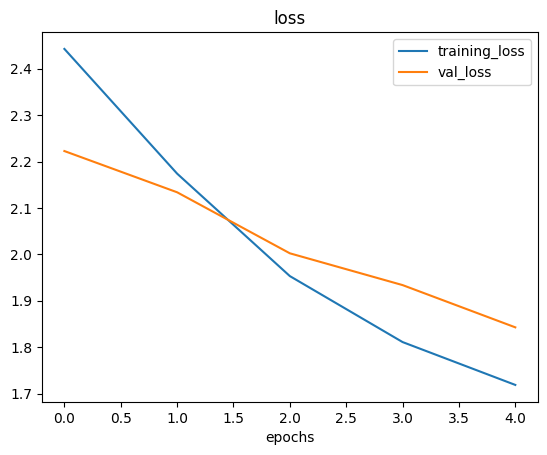

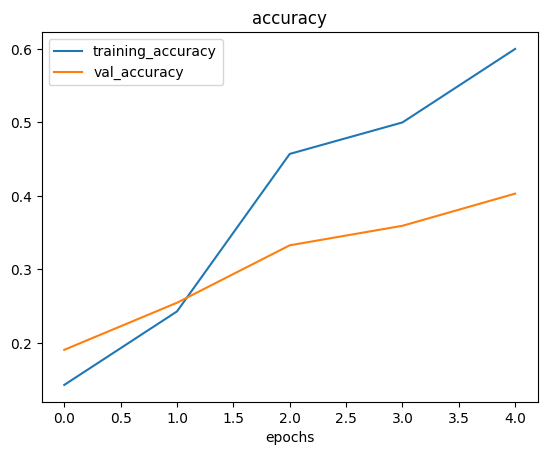

In [22]:
plot_loss_curves(history=model_1_history)

### Creating model checkpoint callback

In [23]:
# Set checkpoint path

checkpoint_path="ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's  weights

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
save_weights_only=True,
save_best_only=False,
save_freq="epoch", # Save every epoch,
verbose=1)


### Model 2: 10% data with augmentation

In [24]:
# Create base model with tf.keras.applications

base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model =>underlying pre-trained patterns aren't updated

base_model.trainable=False

# Create inputs into our model

inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# Normalize in case of using (ResNet50v2)
# x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Data augmentation layer
x= data_augmentation(inputs)


x=base_model(x)

# Average the outputs 

x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)


# Create the output activation layer

outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# Combine inputs with outputs 

model_2 = tf.keras.Model(inputs,outputs)

In [25]:
model_2.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [26]:
model_2_history=model_2.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
        validation_data=test_data,
        validation_steps=0.25*len(test_data),
        # callbacks=[
        #     create_tensorboard_callback(dir_name="transfer_learning",
        #                                 experiment_name="10_percent_data_aug"),
        #     # checkpoint_callback
        #     ],
        
         )

Saving Tensorboard log files to: transfer_learning/10_percent_data_aug/20230320-092417
Epoch 1/5
24/24 [==============================] - 26s 754ms/step - loss: 2.0191 - accuracy: 0.3547 - val_loss: 1.5268 - val_accuracy: 0.6500
Epoch 2/5
24/24 [==============================] - 15s 599ms/step - loss: 1.3829 - accuracy: 0.6853 - val_loss: 1.0830 - val_accuracy: 0.7484
Epoch 3/5
24/24 [==============================] - 12s 486ms/step - loss: 1.0899 - accuracy: 0.7293 - val_loss: 0.8496 - val_accuracy: 0.8109
Epoch 4/5
24/24 [==============================] - 13s 547ms/step - loss: 0.9018 - accuracy: 0.7800 - val_loss: 0.7544 - val_accuracy: 0.8188
Epoch 5/5
24/24 [==============================] - 14s 569ms/step - loss: 0.8361 - accuracy: 0.7840 - val_loss: 0.6991 - val_accuracy: 0.8125


In [28]:
model_0.evaluate(test_data)

79/79 [==============================] - 10s 110ms/step - loss: 0.6118 - accuracy: 0.8400


[0.6118370890617371, 0.8399999737739563]

In [29]:
results_10_percent_data_aug=model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 9s 109ms/step - loss: 0.6992 - accuracy: 0.8072


[0.6991702914237976, 0.807200014591217]

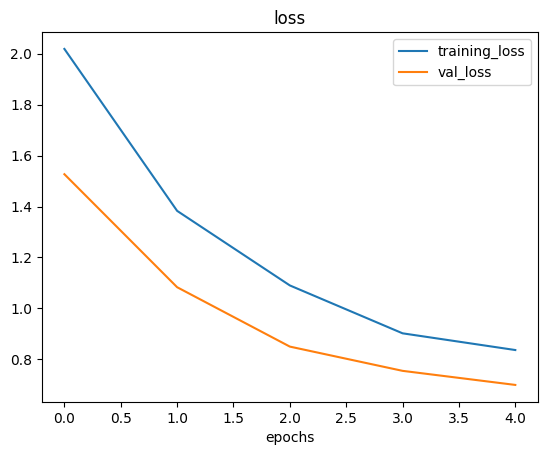

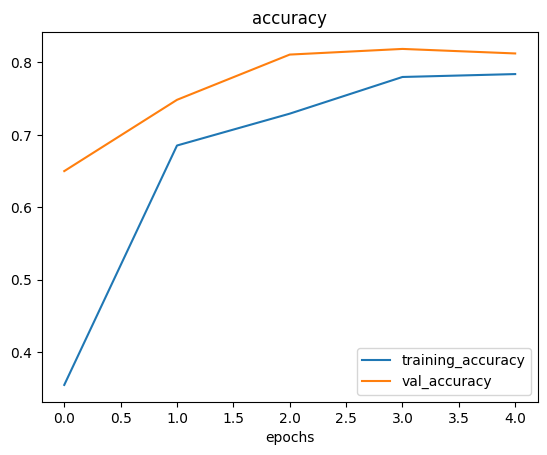

In [30]:
plot_loss_curves(history=model_2_history)

### Loading in checkpointed weights

In [31]:
# Load in saved model weights and evaluate model

model_2.load_weights(checkpoint_path)

In [32]:
# Evaluate model_2 with loaded weights 

loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 9s 110ms/step - loss: 0.7185 - accuracy: 0.8088


In [33]:
results_10_percent_data_aug, loaded_weights_model_results

([0.6991702914237976, 0.807200014591217],
 [0.7184671759605408, 0.8087999820709229])

In [34]:
# Check to see if loaded model results are very close to our previous non-loaded model results

np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([False, False])

## Model 3 : Fine-tuning an existing model on 10% of the data

In [35]:
# Layers in loaded model
model_2.layers

In [36]:
for i,layer in enumerate(model_2.layers[2].layers):
    print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [41]:
# To begin fine tuning , set last 10 layer in base model trainable=True
base_model.trainable=True

# Freeze all layers except last 10 

for layer in base_model.layers[:-10]:
    layer.trainable=False
    
    
# Recompile

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # When fine tuning typically want to lower the learning rate
                metrics=["accuracy"])    


In [44]:
# Check wich layers are trainable

for layer_number,layer in enumerate(model_2.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [46]:
# Refit model (same as model_2)

history_fine_10_percent_data_aug=model_2.fit(
    train_data_10_percent,
    epochs=10,
    validation_data=test_data,
    validation_steps=0.25*len(test_data),
    initial_epoch=model_2_history.epoch[-1],# Start training from last epoch
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
     experiment_name="10_percent_fine_tuned_last_10")]
    
    )

Saving Tensorboard log files to: transfer_learning/10_percent_fine_tuned_last_10/20230320-094615
Epoch 5/10
24/24 [==============================] - 25s 626ms/step - loss: 0.7907 - accuracy: 0.7773 - val_loss: 0.6146 - val_accuracy: 0.7875
Epoch 6/10
24/24 [==============================] - 13s 542ms/step - loss: 0.3963 - accuracy: 0.8787 - val_loss: 0.4799 - val_accuracy: 0.8391
Epoch 7/10
24/24 [==============================] - 12s 481ms/step - loss: 0.2904 - accuracy: 0.9173 - val_loss: 0.4902 - val_accuracy: 0.8422
Epoch 8/10
24/24 [==============================] - 13s 505ms/step - loss: 0.2134 - accuracy: 0.9453 - val_loss: 0.4661 - val_accuracy: 0.8484
Epoch 9/10
24/24 [==============================] - 14s 574ms/step - loss: 0.1693 - accuracy: 0.9587 - val_loss: 0.4303 - val_accuracy: 0.8625
Epoch 10/10
24/24 [==============================] - 12s 460ms/step - loss: 0.1365 - accuracy: 0.9720 - val_loss: 0.4768 - val_accuracy: 0.8500


In [47]:
# Evaluate the fine_tuned model 
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 108ms/step - loss: 0.4893 - accuracy: 0.8408


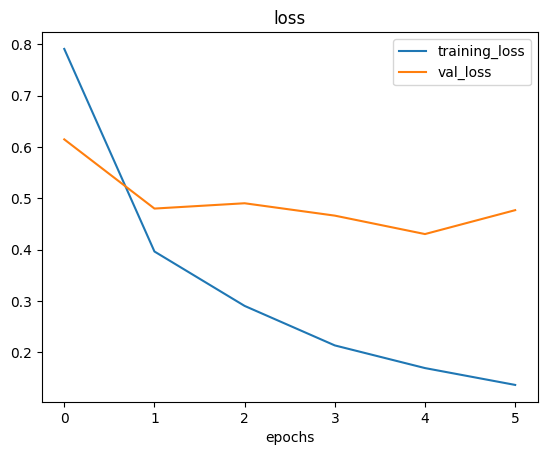

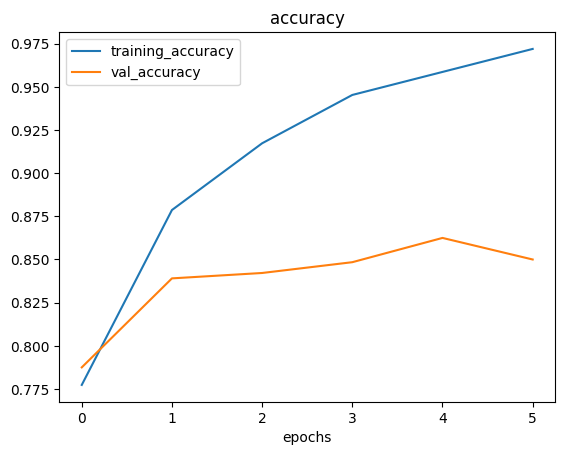

In [48]:
# Check out the loss curves
plot_loss_curves(history_fine_10_percent_data_aug)

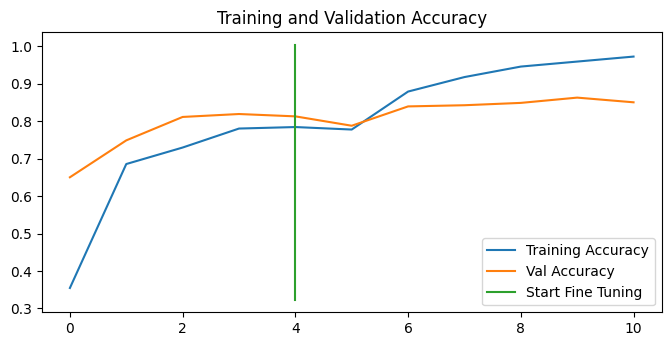

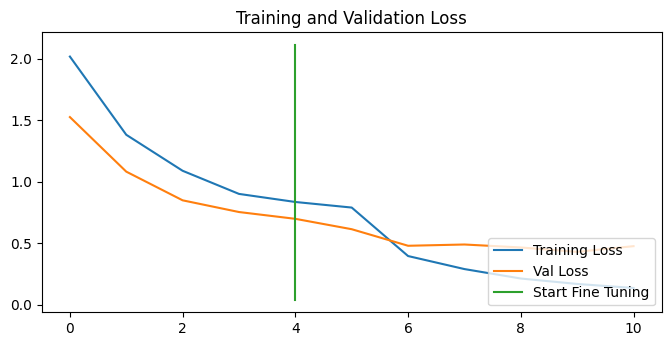

In [61]:
# From the Helper.py file 
compare_histories(model_2_history,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

In [62]:
train_100_percent_dir="10_food_classes_all_data/train/"
test_data="10_food_classes_all_data/test/"

In [63]:
class_names=os.listdir(train_100_percent_dir)

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [67]:
# Setup data inputs

IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_100_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_100_percent_dir,
                            image_size=IMG_SIZE,label_mode="categorical",batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
image_size=IMG_SIZE,
label_mode="categorical",
batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


To train a fine-tuning model(model_4) we need to revert model_2 back to it's feature extraction weights

In [65]:
# Load weights from checkpoint

model_2.load_weights(checkpoint_path)
 

In [66]:
# Check trainable layers

for layer_number,layer in enumerate(model_2.layers):
    print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling True
4 output_layer True


In [68]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # When fine tuning typically want to lower the learning rate
                metrics=["accuracy"])

In [69]:
history_fine_100_percent_data_aug=model_2.fit(
    train_data_100_percent,
    epochs=10,
    validation_data=test_data,
    validation_steps=0.25*len(test_data),
    initial_epoch=model_2_history.epoch[-1],# Start training from last epoch
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
     experiment_name="100_percent_fine_tuned_last_10")]
    
    )

Saving Tensorboard log files to: transfer_learning/100_percent_fine_tuned_last_10/20230320-102759
Epoch 5/10
235/235 [==============================] - 89s 330ms/step - loss: 0.8414 - accuracy: 0.7463 - val_loss: 0.4233 - val_accuracy: 0.8609
Epoch 6/10
235/235 [==============================] - 67s 286ms/step - loss: 0.6644 - accuracy: 0.7935 - val_loss: 0.3867 - val_accuracy: 0.8781
Epoch 7/10
235/235 [==============================] - 61s 260ms/step - loss: 0.5767 - accuracy: 0.8176 - val_loss: 0.3235 - val_accuracy: 0.8844
Epoch 8/10
235/235 [==============================] - 59s 249ms/step - loss: 0.5393 - accuracy: 0.8301 - val_loss: 0.3205 - val_accuracy: 0.8797
Epoch 9/10
235/235 [==============================] - 53s 223ms/step - loss: 0.5025 - accuracy: 0.8417 - val_loss: 0.3170 - val_accuracy: 0.8797
Epoch 10/10
235/235 [==============================] - 51s 214ms/step - loss: 0.4799 - accuracy: 0.8480 - val_loss: 0.3149 - val_accuracy: 0.8813


In [70]:
results_fine_tune_100_percent=model_2.evaluate(test_data)

79/79 [==============================] - 9s 110ms/step - loss: 0.3104 - accuracy: 0.8940


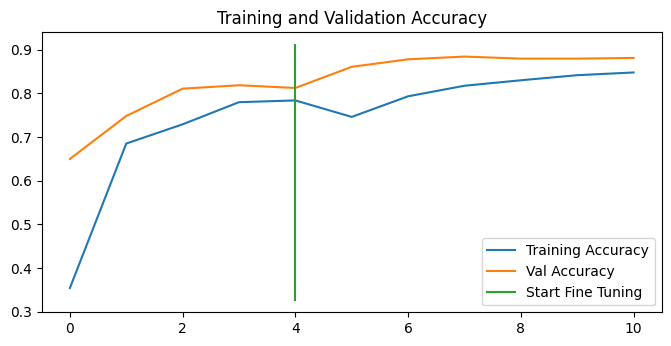

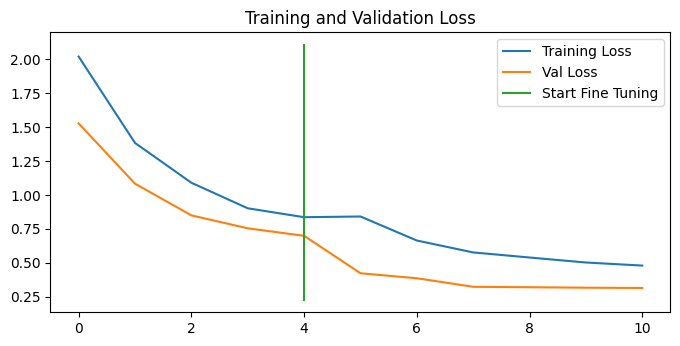

In [75]:
compare_histories(model_2_history,
                  history_fine_100_percent_data_aug,
                  5)